In [ ]:
import pandas as pd

df = pd.read_csv("../data/kc_house_data.csv")
df = df[~df['bedrooms'].between(10, 34)]

df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Определим входные и выходные переменные

Входные Х: col_bedrooms(кол-во спален) и sqft_living(жилплощадь)

Выходные Y: price(цена дома)

#### Создадим лингвистические переменные

In [120]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

col_bedrooms = ctrl.Antecedent(df["bedrooms"].sort_values(), "col_bedrooms")
sqft_living = ctrl.Antecedent(df["sqft_living"].sort_values(), "sqft_living")
price = ctrl.Consequent(df["price"].sort_values(), "price")

### Формирование нечетких переменных для лингвистических переменных и их визуализация

d:\Study\3 курс 5 семестр\AIM\AIM-PIbd-31-Yakovlev-M-G\kernel\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


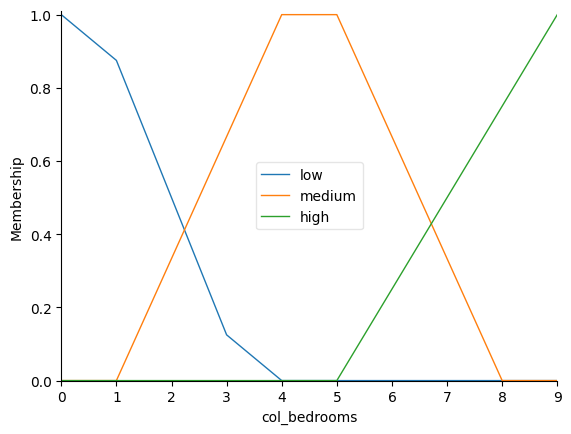

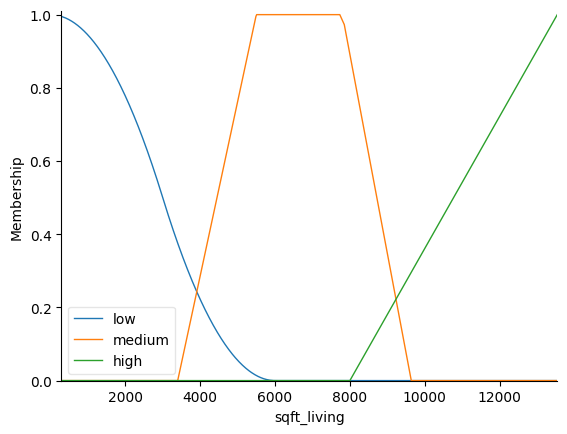

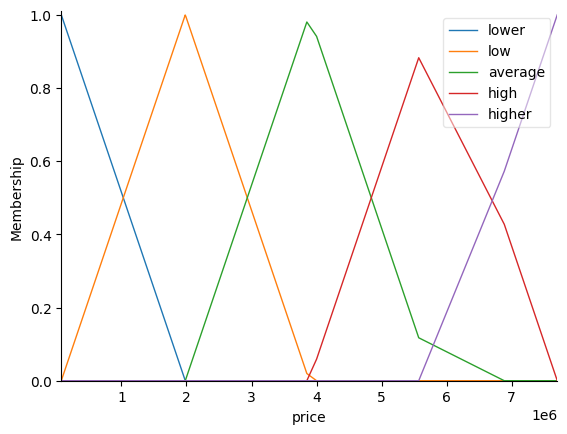

In [121]:
col_bedrooms['low'] = fuzz.zmf(col_bedrooms.universe, 0,4)
col_bedrooms['medium'] = fuzz.trapmf(col_bedrooms.universe, [1, 4, 5, 8])
col_bedrooms['high'] = fuzz.trimf(col_bedrooms.universe, [5,9,9])
col_bedrooms.view()

sqft_living['low'] = fuzz.zmf(sqft_living.universe, 0, 6000)
sqft_living['medium'] = fuzz.trapmf(sqft_living.universe, [3400, 5500, 7800, 9640])
sqft_living['high'] = fuzz.trimf(sqft_living.universe, [8000, 13540,13540])
sqft_living.view()

# price['low'] = fuzz.zmf(price.universe, 0, 2000000)
# price['medium'] = fuzz.trapmf(price.universe, [2000000, 3000000, 4000000, 5500000])
# price['high'] = fuzz.smf(price.universe, 5000000, 7700000)
price.automf(5, variable_type="quant")
price.view()

### Формирование и визуализация базы нечетких правил

(<Figure size 640x480 with 1 Axes>, <Axes: >)

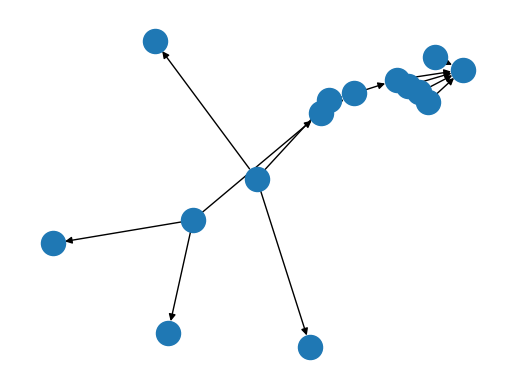

In [122]:
#col_bedrooms sqft_living price
rule1 = ctrl.Rule(col_bedrooms['low'] & sqft_living['low'], price['lower'])
rule2 = ctrl.Rule(col_bedrooms['low'] & sqft_living['medium'], price['low'])
rule3 = ctrl.Rule(col_bedrooms['low'] & sqft_living['high'], price['average'])
rule4 = ctrl.Rule(col_bedrooms['medium'] & sqft_living['low'], price['lower'])
rule5 = ctrl.Rule(col_bedrooms['medium'] & sqft_living['medium'], price['average'])
rule6 = ctrl.Rule(col_bedrooms['medium'] & sqft_living['high'], price['high'])
rule7 = ctrl.Rule(col_bedrooms['high'] & sqft_living['low'], price['average'])
rule8 = ctrl.Rule(col_bedrooms['high'] & sqft_living['medium'], price['high'])
rule9 = ctrl.Rule(col_bedrooms['high'] & sqft_living['high'], price['higher'])

rule1.view()

### Создание нечеткой системы и добавление нечетких правил в базу знаний нечеткой системы

In [123]:
price_ctrl = ctrl.ControlSystem(
    [
        rule1,
        rule2,
        rule3,
        rule4,
        rule5,
        rule6,
        rule7,
        rule8,
        rule9,
    ]
)

prices = ctrl.ControlSystemSimulation(price_ctrl)

### Пример расчета выходной переменной price на основе входных переменных col_bedrooms и sqft_living

In [124]:
prices.input['col_bedrooms'] = 3
prices.input['sqft_living'] = 2570
prices.compute()
prices.print_state()
print(prices.output['price'])

 Antecedents 
Antecedent: col_bedrooms            = 3
  - low                             : 0.125
  - medium                          : 0.6666666666666666
  - high                            : 0.0
Antecedent: sqft_living             = 2570
  - low                             : 0.6330611111111111
  - medium                          : 0.0
  - high                            : 0.0

 Rules 
RULE #0:
  IF col_bedrooms[low] AND sqft_living[low] THEN price[lower]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - col_bedrooms[low]                                      : 0.125
  - sqft_living[low]                                       : 0.6330611111111111
                    col_bedrooms[low] AND sqft_living[low] = 0.125
  Activation (THEN-clause):
                                              price[lower] : 0.125

RULE #1:
  IF col_bedrooms[low] AND sqft_living[medium] THEN price[low]
	AND aggregation function : fmin
	OR aggregation function  : fm

### Тестирование нечеткой системы

In [125]:
def fuzzy_pred(row):
    prices.input['col_bedrooms'] = row['bedrooms']
    prices.input['sqft_living'] = row['sqft_living']
    prices.compute()
    return prices.output['price']

res = df[['bedrooms', 'sqft_living', 'price']].head(100)

res['Pred'] = res.apply(fuzzy_pred, axis=1)

res.head(15)

bedrooms  sqft_living      price          Pred
0          3         1180   221900.0  7.633710e+05
1          3         2570   538000.0  7.730085e+05
2          2          770   180000.0  8.163228e+05
3          4         1960   604000.0  7.342715e+05
4          3         1680   510000.0  7.633710e+05
5          4         5420  1225000.0  3.907144e+06
6          3         1715   257500.0  7.633710e+05
7          3         1060   291850.0  7.633710e+05
8          3         1780   229500.0  7.633710e+05
9          3         1890   323000.0  7.633710e+05
10         3         3560   662500.0  2.194984e+06
11         2         1160   468000.0  8.163228e+05
12         3         1430   310000.0  7.633710e+05
13         3         1370   400000.0  7.633710e+05
14         5         1810   530000.0  7.282272e+05

### Оценка результатов на основе метрик для задачи регрессии

In [126]:
import math
from sklearn import metrics


rmetrics = {}
rmetrics["RMSE"] = math.sqrt(metrics.mean_squared_error(res['price'], res['Pred']))
rmetrics["RMAE"] = math.sqrt(metrics.mean_absolute_error(res['price'], res['Pred']))
rmetrics["R2"] = metrics.r2_score(res['price'], res['Pred'])

rmetrics

{'RMSE': 648551.3362363386,
 'RMAE': 675.5893884070558,
 'R2': -3.582200641088188}